# JRA and bulk fluxes

tas 10 m air temperature (θA) K TL319 (0.5625°) 0:00 1 Jan 3-h, snapshot

huss 10 m specific humidity (qA) kg kg−1 TL319 (0.5625°) 0:00 1 Jan 3-h, snapshot

uas 10 m eastward wind (→UA) m s−1 TL319 (0.5625°) 0:00 1 Jan 3-h, snapshot

vas 10 m northward wind (→UA) m s−1 TL319 (0.5625°) 0:00 1 Jan 3-h, snapshot

psl Sea level pressure (SLP) Pa TL319 (0.5625°) 0:00 1 Jan 3-h, snapshot

rsds Downward shortwave (QDSW) W m−2 TL319 (0.5625°) 1:30 1 Jan 3-h, mean

rlds Downward longwave (QDLW) W m−2 TL319 (0.5625°) 1:30 1 Jan 3-h, mean

prra Rainfall flux (P) kg/m²/s  TL319 (0.5625°) 1:30 1 Jan 3-h, mean

prsn Snowfall flux (P) kg/m²/s TL319 (0.5625°) 1:30 1 Jan 3-h, mean

friver Total river runoffa (R) kg/m²/s 0.25° × 0.25° 1 Jan Day, mean

# setup

In [ ]:
import dask_jobqueue

if "cluster" in locals():
    cluster.close()

env = {"OMP_NUM_THREADS": "3", "NUMBA_NUM_THREADS": "3"}

# cluster = distributed.LocalCluster(
#    n_workers=8,
#    threads_per_worker=1,
#    env=env
# )

cluster = dask_jobqueue.SLURMCluster(
    cores=1, processes=1, memory="25GB", walltime="02:00:00", project="NCGD0046",
)

# cluster = dask_jobqueue.PBSCluster(
#    cores=9, processes=9, memory="108GB", walltime="02:00:00", project="NCGD0043",
#    env_extra=env,
# )
# cluster.adapt(minimum_jobs=2, maximum_jobs=6, wait_count=300)
cluster.scale(6)

/glade/u/home/dcherian/miniconda3/envs/dcpy2/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [ ]:
%load_ext autoreload
# %autoreload 2

%matplotlib inline

import hvplot.xarray
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.units as munits
import numpy as np
import pandas as pd
import seawater as sw

%aimport xarray
import xarray as xr

# from distributed import performance_report

%aimport dcpy
%aimport pump

# import facetgrid

mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["figure.dpi"] = 140

munits.registry[np.datetime64] = mdates.ConciseDateConverter()
xr.set_options(keep_attrs=False)
# print(dask.__version__)
# print(distributed.__version__)
print(xr.__version__)
xr.DataArray([1.0])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0.15.1


<xarray.DataArray (dim_0: 1)>
array([1.])
Dimensions without coordinates: dim_0

In [ ]:
if "client" in locals():
    client.close()

import distributed

client = distributed.Client(cluster)
client

<Client: 'tcp://10.12.205.11:33758' processes=6 threads=6, memory=150.00 GB>

In [ ]:
import dask

dask.array.ones((10000,), chunks=(100,)).compute()

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
gcm1 = pump.model.model.Model(
    "../TPOS_MITgcm_1_hb/HOLD_NC_LINKS/", name="gcm1", full=True, budget=True,
)
# gcm1.tao.load()
# gcm1.tao = xr.merge([gcm1.tao, pump.calc.get_tiw_phase(gcm1.tao.v)])
gcm1.surface["zeta"] = xr.open_dataset(gcm1.dirname + "obs_subset/surface_zeta.nc").zeta
# gcm1.surface = gcm1.surface.chunk({"time": 1})
# gcm1.surface["zeta"] = gcm1.surface.v.differentiate("longitude") - gcm1.surface.u.differentiate("latitude")

Reading all files took 103.60689735412598 seconds
calc uz
calc vz
calc S2
calc N2
calc shred2
Calc Ri


## Test COARE + JRA against  gcm1

things work to an error of 10W/m². I need to cool by this amount for residual to look random

In [ ]:
jrafull = xr.concat(
    [
        pump.obs.read_jra(
            "/glade/campaign/cgd/oce/people/bachman/make_TPOS_MITgcm/JRA_FORCING/1995/JRA55DO*[0-9].nc",
            chunks={"time": 1200},
        ),
    ],
    dim="time",
)
jrafull["time"] = jrafull.time  # - pd.Timedelta("h")
jrafull

<xarray.Dataset>
Dimensions:    (latitude: 42, longitude: 134, time: 1954)
Coordinates:
  * longitude  (longitude) float64 -169.9 -169.3 -168.8 ... -96.19 -95.62 -95.06
  * latitude   (latitude) float64 -11.51 -10.95 -10.39 ... 10.39 10.95 11.51
  * time       (time) datetime64[ns] 1995-08-31T21:00:00 ... 1995-12-31T22:30:00
Data variables:
    huss       (time, latitude, longitude) float32 dask.array<chunksize=(1954, 42, 134), meta=np.ndarray>
    prra       (time, latitude, longitude) float32 dask.array<chunksize=(1954, 42, 134), meta=np.ndarray>
    psl        (time, latitude, longitude) float32 dask.array<chunksize=(1954, 42, 134), meta=np.ndarray>
    rlds       (time, latitude, longitude) float32 dask.array<chunksize=(1954, 42, 134), meta=np.ndarray>
    rsds       (time, latitude, longitude) float32 dask.array<chunksize=(1954, 42, 134), meta=np.ndarray>
    tas        (time, latitude, longitude) float32 dask.array<chunksize=(1954, 42, 134), meta=np.ndarray>
    uas        (time, latitude, longitude) float32 dask.array<chunksize=(1954, 42, 134), meta=np.ndarray>
    vas        (time, latitude, longitude) float32 dask.array<chunksize=(1954, 42, 134), meta=np.ndarray>
Attributes:
    About:    Created with SOSIE interpolation environement => https://github...
    history:  Fri Mar  1 10:12:33 2019: ncks -d time,1943,2919 JRA55DO_1.3_Pa...
    NCO:      netCDF Operators version 4.7.4 (http://nco.sf.net)

In [ ]:
station = xr.merge(
    [
        gcm1.tao.sel(latitude=0, longitude=-110).sel(time="1995"),
        gcm1.budget.sel(latitude=0, longitude=-110, method="nearest")[
            ["oceQsw", "oceQnet"]
        ].sel(time="1995"),
    ],
    compat="override",
)
station["time"] = station.time  # - pd.Timedelta("7h")
station

<xarray.Dataset>
Dimensions:          (depth: 284, time: 732)
Coordinates:
    latitude         float64 0.0
    longitude        float64 -110.0
  * depth            (depth) float32 -0.5 -1.5 -2.5 ... -458.8152 -479.7476
  * time             (time) datetime64[ns] 1995-09-01 ... 1995-12-31T20:00:00
Data variables:
    TOTTTEND         (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    ADVx_TH          (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    ADVy_TH          (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    ADVr_TH          (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    DFrI_TH          (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    KPPg_TH          (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    WTHMASS          (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    oceQnet          (time) float32 dask.array<chunksize=(732,), meta=np.ndarray>
    oceQsw           (time) float32 dask.array<chunksize=(732,), meta=np.ndarray>
    TFLUX            (time) float32 dask.array<chunksize=(732,), meta=np.ndarray>
    theta            (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    u                (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    v                (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    w                (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    salt             (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    KPP_diffusivity  (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    dens             (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    uz               (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    vz               (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    S2               (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    shear            (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    N2               (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    shred2           (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    Ri               (time, depth) float32 dask.array<chunksize=(732, 284), meta=np.ndarray>
    euc_max          (time) float64 -91.5 -93.5 -94.5 ... -89.5 -91.5 -93.5
    mld              (time) float32 dask.array<chunksize=(732,), meta=np.ndarray>
    dcl_base_shear   (time) float64 -22.5 -23.5 -24.5 ... -83.5 -85.5 -86.5
    dcl_base_Ri      (time) float32 dask.array<chunksize=(732,), meta=np.ndarray>
    Jq               (time, depth) float64 dask.array<chunksize=(732, 284), meta=np.ndarray>

In [ ]:
jrasub = jrafull.interp(latitude=0.025, longitude=-110.01001).compute()
jrasub["time"] = jrasub.time.dt.floor("h")  # workaround. see below
jrai = jrasub.interpolate_na("time").compute()

In [ ]:
time = "1995-Nov"


fluxes = pump.calc.coare_fluxes_jra(
    station.sel(time=time), jrai.interp(time=station.sel(time=time).time)
)
(
    fluxes.total.hvplot() * station.sel(time=time).TFLUX.hvplot()
    + (fluxes.total - station.sel(time=time).TFLUX).hvplot()
)


# coare.hlb.plot()
# plt.figure()
# (coare.Q10/1000).plot()
# jrai.interp(time=station.sel(time=time).time).huss.plot()

AttributeError: 'Dataset' object has no attribute 'total'

# bug in processing radiation fields for input

For some reason it looks like the radiation fields are a half hour displaced in time. The radiation fields are supposed to be at 3hourly starting at 01:30 on a day. mitgcm seems to think they start at 01:00 on the day. I suspect the half hour was lost because the time vector was written as `int` in the binary files. Note netcdf file time units are in fractions of day.

In the below, blue is the original JRA time series, orange is interpolated to model output timesteps, and green is model output for shortwave radiation. Orange and green should coincide exactly with `albedo = 0.1`

In [ ]:
time = slice("1995-11-15", "1995-11-17")

newtime = station.sel(time=time).time

raw = (0.9 * jrasub).rsds.dropna("time").sel(time=time)
raw["time"] = raw.time

(
    raw.hvplot()
    * raw.interp(time=newtime).hvplot()
    * station.sel(time=time).oceQsw.hvplot()
)

:Overlay
   .Curve.I   :Curve   [time]   (rsds)
   .Curve.II  :Curve   [time]   (rsds)
   .Curve.III :Curve   [time]   (oceQsw)

With a half hour offset, orange and green coincide

In [ ]:
raw["time"] = raw.time - pd.Timedelta("0.5h")

(
    raw.hvplot()
    * raw.interp(time=newtime).hvplot()
    * station.sel(time=time).oceQsw.hvplot()
)

:Overlay
   .Curve.I   :Curve   [time]   (rsds)
   .Curve.II  :Curve   [time]   (rsds)
   .Curve.III :Curve   [time]   (oceQsw)

# test with 20 year simulation

don't add time zone offset since model output is daily mean in GMT

In [ ]:
time = xr.Dataset({"time": (2.16e7)})
time.time.attrs["units"] = "seconds since 1979-01-01"
xr.decode_cf(time)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    time     datetime64[ns] ...

In [ ]:
jrafull = pump.obs.read_jra_20()
station = pump.model.model.read_stations_20("../TPOS_MITgcm_fix3/", "*110.000*.nc")
station

<xarray.Dataset>
Dimensions:        (depth: 185, latitude: 111, time: 24000)
Coordinates:
  * latitude       (latitude) float64 -3.075 -3.025 -2.975 ... 5.925 5.975 6.025
  * depth          (depth) float32 -1.25 -3.75 -6.25 ... -5658.0986 -5758.0986
    longitude      float32 ...
  * time           (time) datetime64[ns] 1998-12-31T18:00:00 ... 2001-09-26T17:00:00
Data variables:
    SSH            (time, latitude) float32 dask.array<chunksize=(6000, 1), meta=np.ndarray>
    KPPhbl         (time, latitude) float32 dask.array<chunksize=(6000, 1), meta=np.ndarray>
    u              (depth, time, latitude) float32 dask.array<chunksize=(185, 6000, 1), meta=np.ndarray>
    v              (depth, time, latitude) float32 dask.array<chunksize=(185, 6000, 1), meta=np.ndarray>
    w              (depth, time, latitude) float32 dask.array<chunksize=(185, 6000, 1), meta=np.ndarray>
    theta          (depth, time, latitude) float32 dask.array<chunksize=(185, 6000, 1), meta=np.ndarray>
    salt           (depth, time, latitude) float32 dask.array<chunksize=(185, 6000, 1), meta=np.ndarray>
    DFrI_TH        (depth, time, latitude) float32 dask.array<chunksize=(185, 6000, 1), meta=np.ndarray>
    VISrI_Um       (depth, time, latitude) float32 dask.array<chunksize=(185, 6000, 1), meta=np.ndarray>
    VISrI_Vm       (depth, time, latitude) float32 dask.array<chunksize=(185, 6000, 1), meta=np.ndarray>
    KPPdiffKzT     (depth, time, latitude) float32 dask.array<chunksize=(185, 6000, 1), meta=np.ndarray>
    KPPviscAz      (depth, time, latitude) float32 dask.array<chunksize=(185, 6000, 1), meta=np.ndarray>
    KPPg_TH        (depth, time, latitude) float32 dask.array<chunksize=(185, 6000, 1), meta=np.ndarray>
    Jq             (depth, time, latitude) float64 dask.array<chunksize=(185, 6000, 1), meta=np.ndarray>
    nonlocal_flux  (depth, time, latitude) float64 dask.array<chunksize=(185, 6000, 1), meta=np.ndarray>
    dens           (depth, time, latitude) float32 dask.array<chunksize=(185, 6000, 1), meta=np.ndarray>
Attributes:
    title:     Station profile, index (i,j)=(1200,240)
    easting:   longitude
    northing:  latitude

In [ ]:
subset = (
    station.sel(time=slice(exf.time[0], exf.time[-1]))
    .sel(latitude=0, method="nearest")
    .compute()
)
subset

<xarray.Dataset>
Dimensions:        (depth: 185, time: 169)
Coordinates:
  * depth          (depth) float32 -1.25 -3.75 -6.25 ... -5658.0986 -5758.0986
    longitude      float32 -110.025
    latitude       float64 0.025
  * time           (time) datetime64[ns] 1999-09-07T17:00:00 ... 1999-09-14T17:00:00
Data variables:
    SSH            (time) float32 0.25519955 0.25225362 ... 0.24087271
    KPPhbl         (time) float32 4.674738 5.5329742 ... 11.593049 13.097585
    u              (depth, time) float32 -0.9419909 -0.9302492 ... 0.0 0.0
    v              (depth, time) float32 -0.2366631 -0.24049091 ... -0.0 -0.0
    w              (depth, time) float32 6.1781943e-06 4.9131977e-06 ... -0.0
    theta          (depth, time) float32 23.256327 23.221409 ... 0.0 0.0
    salt           (depth, time) float32 34.406025 34.40682 ... 0.0 0.0
    DFrI_TH        (depth, time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VISrI_Um       (depth, time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VISrI_Vm       (depth, time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    KPPdiffKzT     (depth, time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    KPPviscAz      (depth, time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    KPPg_TH        (depth, time) float32 0.0 0.0 0.0 0.0 ... -0.0 -0.0 -0.0 0.0
    Jq             (depth, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nonlocal_flux  (depth, time) float64 0.0 0.0 0.0 0.0 ... -0.0 -0.0 -0.0 0.0
    dens           (depth, time) float64 1.023e+03 1.023e+03 ... 999.8 999.8
    long           (time) float64 -71.11 -70.75 -70.46 ... -75.66 -75.84 -75.82
    short          (time) float64 47.11 31.41 15.7 0.0 ... 381.1 212.7 44.29
    sens           (time) float64 -7.624 -8.125 -8.757 ... -3.802 -3.996 -3.91
    lat            (time) float64 -61.37 -59.61 -58.28 ... -52.06 -51.43 -50.02
    netflux        (time) float64 -92.99 -107.1 -121.8 ... 249.6 81.43 -85.46
    stress         (time) float64 0.0186 0.01908 0.01977 ... 0.03402 0.03349
    taux           (time) float64 -0.01087 -0.01227 ... -0.02506 -0.02411
    tauy           (time) float64 0.01509 0.0146 0.01418 ... 0.02301 0.02324
    usr            (time) float64 0.1255 0.1271 0.1294 ... 0.1701 0.1689 0.1676
    tau            (time) float64 0.0186 0.01908 0.01977 ... 0.03402 0.03349
    hsb            (time) float64 7.624 8.125 8.757 9.428 ... 3.802 3.996 3.91
    hlb            (time) float64 61.37 59.61 58.28 57.06 ... 52.06 51.43 50.02
    hbb            (time) float64 12.07 12.44 12.97 13.55 ... 7.562 7.71 7.522
    hsbb           (time) float64 11.34 11.73 12.28 12.88 ... 6.946 7.101 6.93
    hlwebb         (time) float64 2.183 2.221 2.283 2.353 ... 1.541 1.548 1.507
    tsr            (time) float64 -0.05036 -0.053 -0.05611 ... -0.01962 -0.01935
    qsr            (time) float64 -0.163 -0.1563 -0.1501 ... -0.1015 -0.09948
    zot            (time) float64 0.00016 0.00016 0.00016 ... 0.0001578 0.00016
    zoq            (time) float64 0.00016 0.00016 0.00016 ... 0.0001578 0.00016
    Cd             (time) float64 0.001039 0.001039 ... 0.001007 0.001005
    Ch             (time) float64 0.001361 0.00136 ... 0.001232 0.001232
    Ce             (time) float64 0.001361 0.00136 ... 0.001232 0.001232
    L              (time) float64 -14.91 -15.02 -15.19 ... -59.13 -56.75 -56.81
    zet            (time) float64 -0.6706 -0.6658 -0.6585 ... -0.1762 -0.176
    dter           (time) float64 0.2716 0.267 0.2625 ... 0.1826 0.1912 0.1981
    dqer           (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    tkt            (time) float64 0.001279 0.001268 ... 0.001002 0.001008
    Urf            (time) float64 3.83 3.879 3.949 4.039 ... 5.327 5.288 5.253
    Trf            (time) float64 21.97 21.87 21.77 21.67 ... 21.41 21.35 21.28
    Qrf            (time) float64 13.56 13.67 13.78 13.89 ... 13.5 13.49 13.48
    RHrf           (time) float64 82.7 83.91 85.12 86.36 ... 85.07 85.31 85.55
    UrfN   

In [ ]:
forcing = pump.obs.interp_jra_to_station(jrafull, subset)
fluxes, coare = pump.calc.coare_fluxes_jra(subset, forcing)
subset = subset.merge(forcing).merge(fluxes)
subset

<xarray.Dataset>
Dimensions:    (depth: 125, time: 169)
Coordinates:
  * depth      (depth) float32 -1.25 -3.75 -6.25 ... -464.57806 -487.70044
    longitude  float32 -110.025
    latitude   float64 0.025
  * time       (time) datetime64[ns] 1999-09-07T17:00:00 ... 1999-09-14T17:00:00
Data variables:
    hbl        (time) float32 5.0 5.0 5.0 7.5 ... 2.967203 4.9456835 12.5 12.5
    hekman     (time) float32 nan nan nan ... 4.0423456e+17 4.0130446e+17 nan
    hmonob     (time) float32 nan nan nan nan ... 4.9456835 19.041367 nan
    hunlimit   (time) float32 5.0 5.0 5.0 7.5 7.5 7.5 ... 5.0 5.0 7.5 12.5 12.5
    Rib        (time, depth) float32 -0.0 0.2515793 ... 22.572714 22.572714
    db         (time, depth) float32 -0.0 0.00027189835 ... 12.947336 0.0
    dV2        (time, depth) float32 0.0 0.00052615284 ... 0.54307663 0.0
    dVt2       (time, depth) float32 0.00018341177 0.00055461295 ... 0.0
    KT         (time, depth) float32 0.00047199478 0.0023720313 ... 1e-06 1e-06
    KM         (time, depth) float32 0.00057099474 0.0017977662 ... 1e-04 1e-04

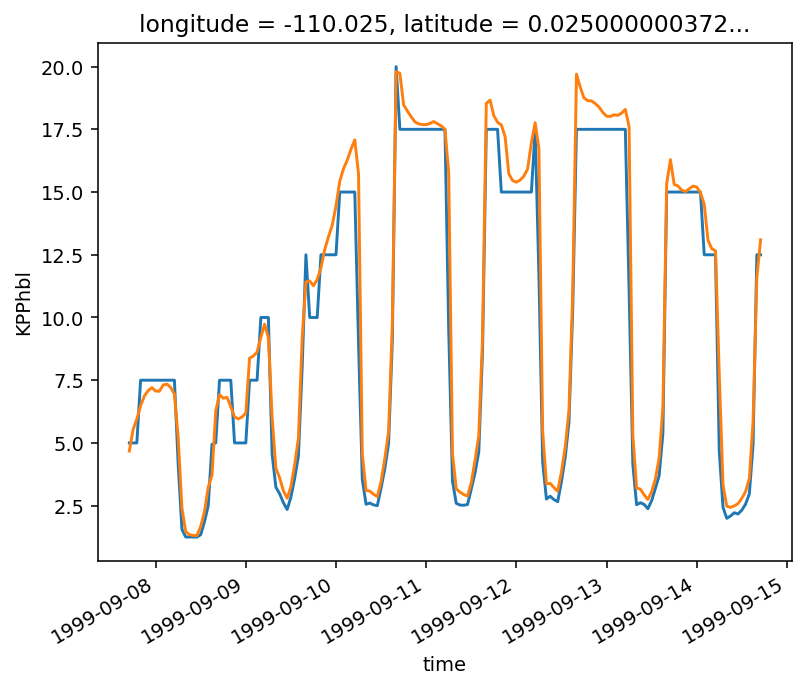

In [ ]:
pump.calc.calc_kpp_hbl(subset, debug=True)

## Check against EXF output

In [ ]:
kpp2 = xr.open_mfdataset(
    "/glade/scratch/bachman/TPOS_MITgcm_20_year/HOLD/*KPP2D*.nc", parallel=True,
).sel(latitude=0, longitude=-110, method="nearest")
kpp3 = xr.open_mfdataset(
    "/glade/scratch/bachman/TPOS_MITgcm_20_year/HOLD/*KPP3D*.nc", parallel=True,
).sel(latitude=0, longitude=-110, method="nearest")

kpp = xr.merge([kpp2, kpp3])
kpp["time"] = kpp.time + pd.Timedelta("23h") - pd.Timedelta("7h")
# kpp.load()

exf = xr.open_mfdataset(
    "/glade/scratch/bachman/TPOS_MITgcm_20_year/HOLD/*sfc.nc", parallel=True
).sel(latitude=0, longitude=-110, method="nearest")
exf["time"] = exf.time + pd.Timedelta("23h") - pd.Timedelta("7h")
exf.load()

station2 = xr.open_mfdataset(
    "/glade/scratch/bachman/TPOS_MITgcm_20_year/HOLD/*buoy.nc", parallel=True
).sel(latitude=0, longitude=-110, method="nearest")
station2["time"] = station2.time + pd.Timedelta("23h") - pd.Timedelta("7h")

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.15 this will

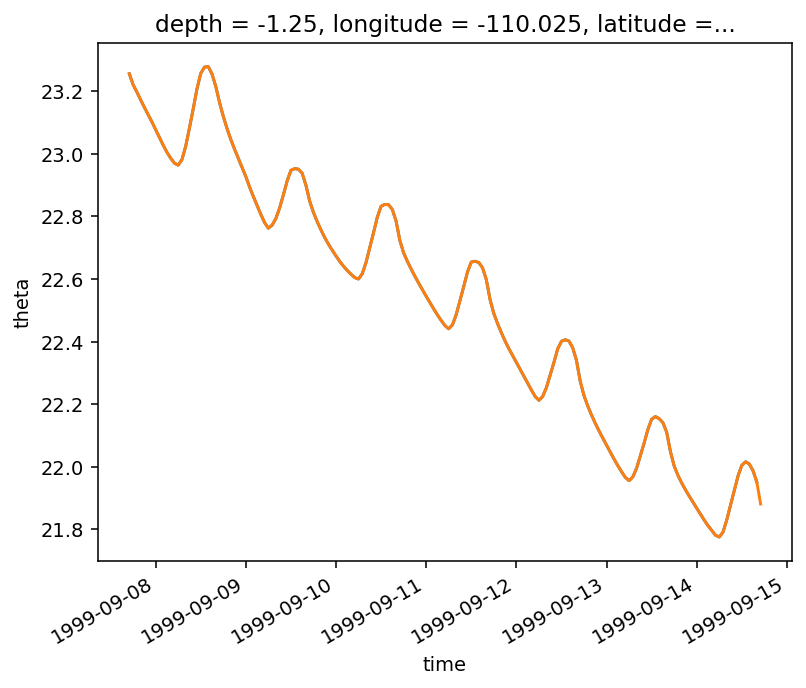

In [ ]:
station2.isel(depth=0).theta.plot()
subset.theta.isel(depth=0).plot()

#### shortwave

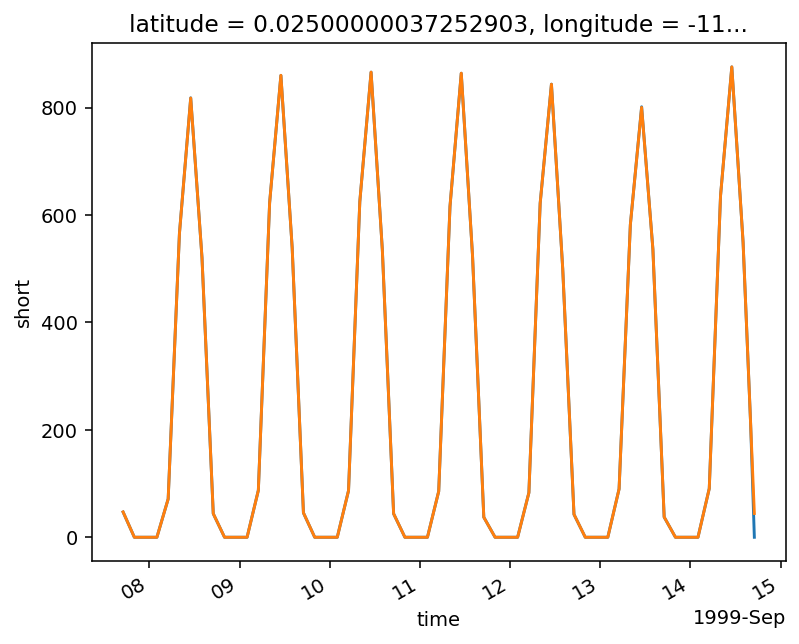

In [ ]:
# (0.9 * jrai).rsds.plot()
(-1 * exf.EXFswnet).fillna(0).plot()
(fluxes.short).plot()

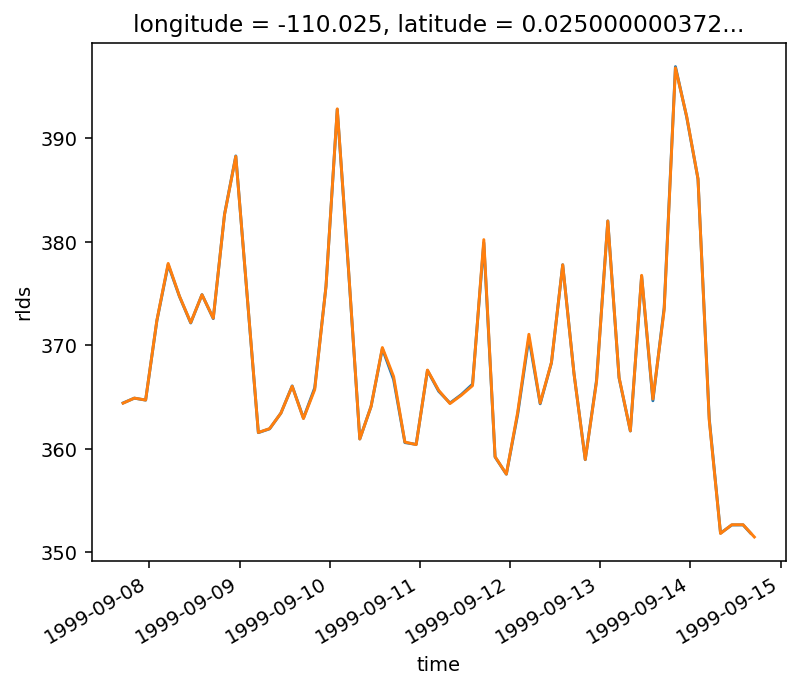

In [ ]:
exf.EXFlwdn.plot()
forcing.rlds.plot()

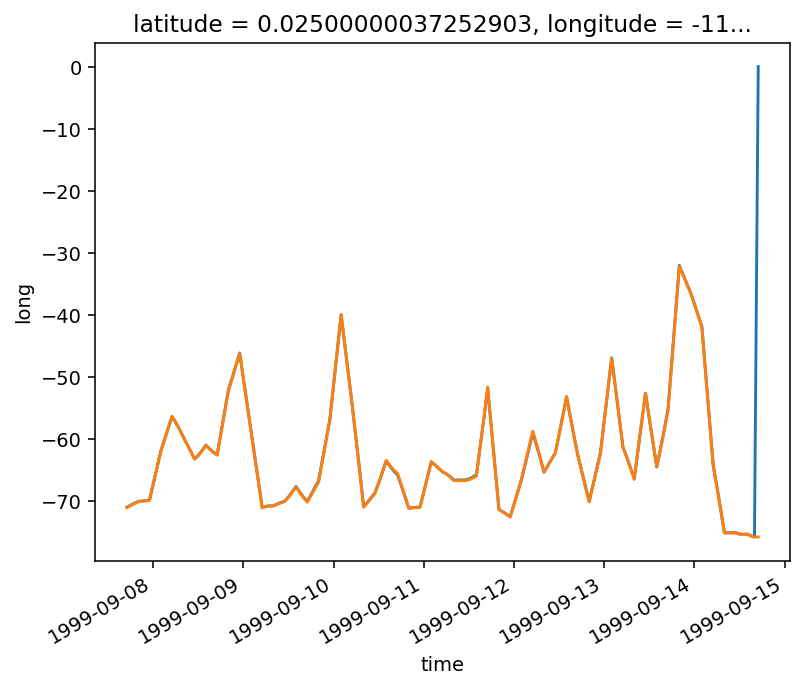

In [ ]:
# jra.assign_coords(time=jra.time - pd.Timedelta("24h")).rsds.sel(latitude=0, method="nearest").dropna("time").plot()
# (0.9*jrai).sel(latitude=0, method="nearest").rsds.plot()
(-1 * exf.EXFlwnet).fillna(0).plot()
(fluxes.long).plot()
#(
#    -0.97
#    * (
#        5.67e-8 * (subset.theta.sel(depth=0, method="nearest") + 273.16) ** 4
#        - forcing.rlds
#    )
#).plot()

In [ ]:
np.hypot(exf.EXFtaux, exf.EXFtauy).hvplot() * (coare.tau).hvplot()

:Overlay
   .Curve.I  :Curve   [time]   (value)
   .Curve.II :Curve   [time]   (tau)

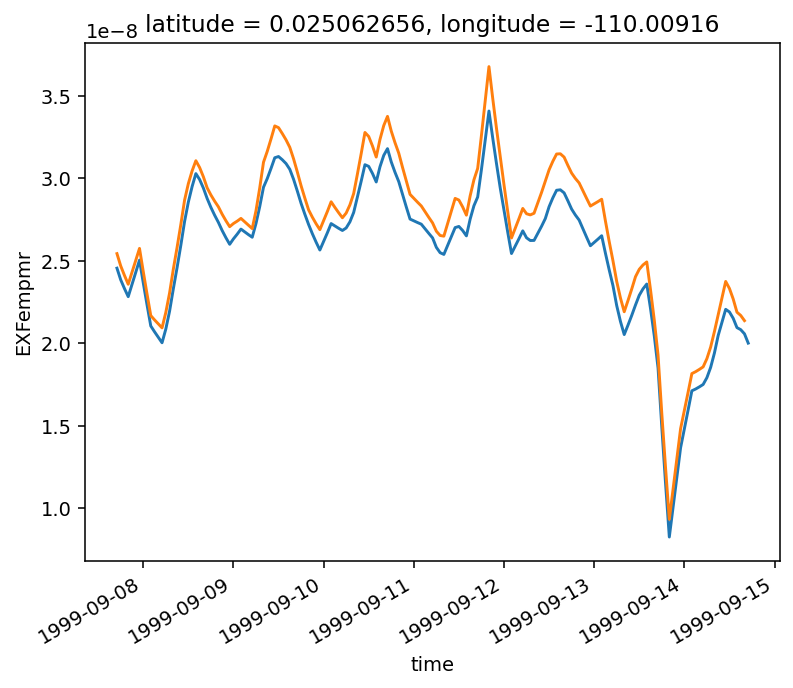

In [ ]:
(coare.Evap * 1e-3 / 3600 - forcing.prra / 1000).plot()
exf.EXFempmr.plot()

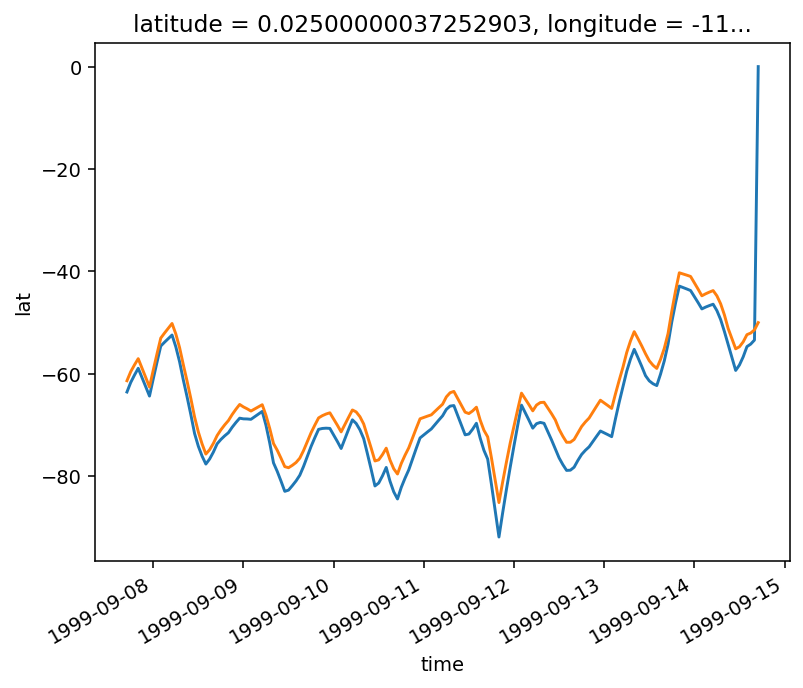

In [ ]:
(exf.EXFhl).fillna(0).plot()
(fluxes.lat).plot()

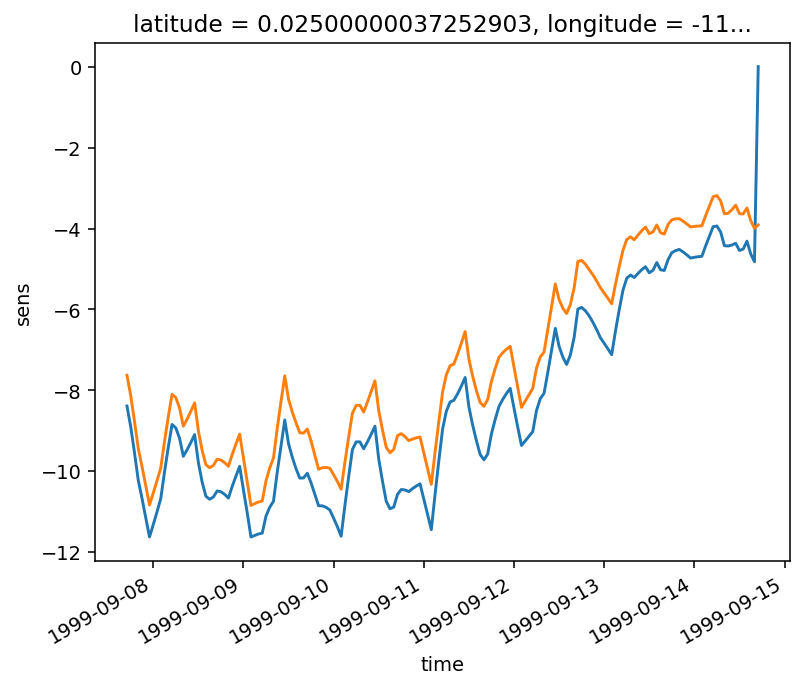

In [ ]:
(exf.EXFhs).fillna(0).plot()
(fluxes.sens).plot()

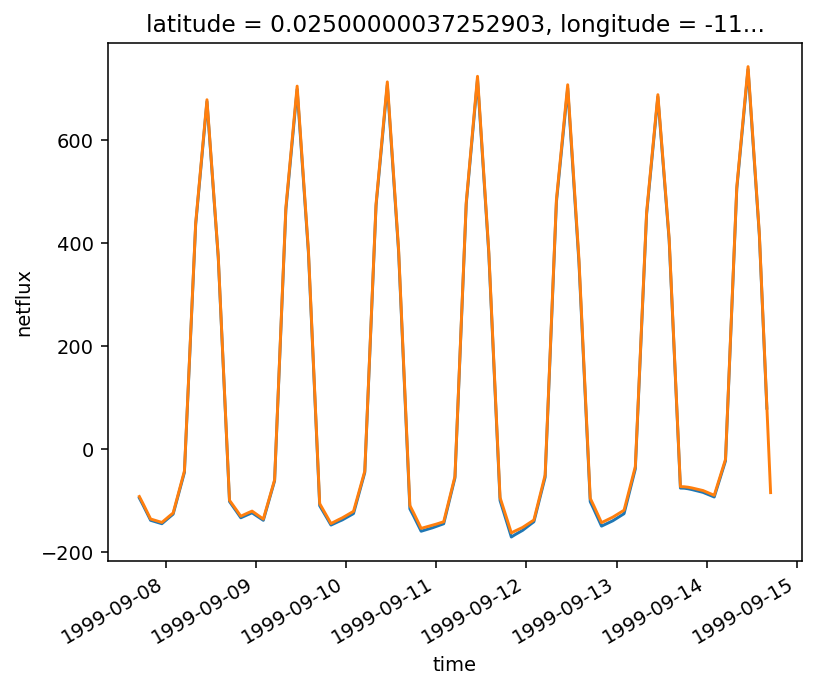

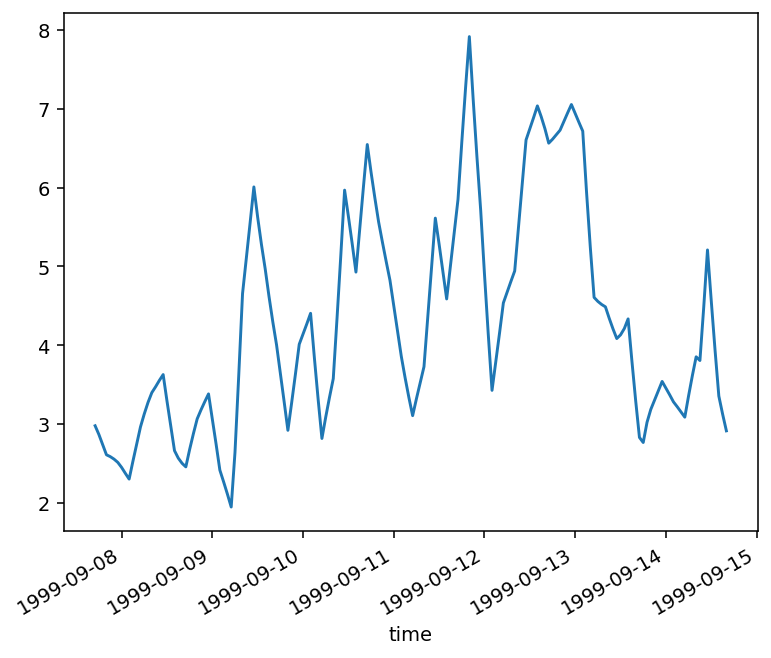

In [ ]:
(-1 * exf.EXFqnet).plot()
fluxes.netflux.plot()

plt.figure()
(fluxes.netflux + exf.EXFqnet).plot()

In [ ]:
expected = xr.open_mfdataset(
    "/glade/campaign/cgd/oce/people/bachman/TPOS_MITgcm_fix3/*00[0-9][0-9]*surf.nc",
    parallel=True,
    chunks={"time": 1},
)
# expected["time"] = expected.time - pd.Timedelta("7h")

/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/glade/u/home/dcherian/miniconda3/envs/dcpy/lib/python3.6/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


Things look good! I could take the daily error and distribute that in time uniformly in my hourly net flux time series

In [ ]:
actual = fluxes.sel(time=slice(expected.time[0], expected.time[-1]))

(
    actual.total.resample(time="D").mean().hvplot()
    * expected.TFLUX.sel(latitude=0, longitude=-110, method="nearest").hvplot(x="time")
)

:Overlay
   .Curve.I  :Curve   [time]   (total)
   .Curve.II :Curve   [time]   (TFLUX)

# KPP

In [ ]:
kpp["KPPhbl"].load()
kpp["KPPRi"].load()

<xarray.DataArray 'KPPRi' (time: 169, depth: 136)>
array([[        nan,  0.25667801,  0.3622313 , ..., 17.544111  ,
        19.860975  , 23.414364  ],
       [        nan,  0.19507883,  0.33876625, ..., 17.295212  ,
        19.528172  , 22.946148  ],
       [        nan,  0.18531531,  0.31263912, ..., 16.956198  ,
        19.09329   , 22.357182  ],
       ...,
       [        nan,  0.23823726,  0.28394794, ..., 44.584606  ,
        53.7969    , 72.55146   ],
       [        nan,  0.12861234,  0.20178862, ..., 44.91574   ,
        54.139973  , 73.126785  ],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 1999-09-07T17:00:00 ... 1999-09-14T17:00:00
    latitude   float32 0.025062656
    longitude  float32 -110.00916
  * depth      (depth) float32 -1.25 -3.75 -6.25 ... -881.6718 -944.4181

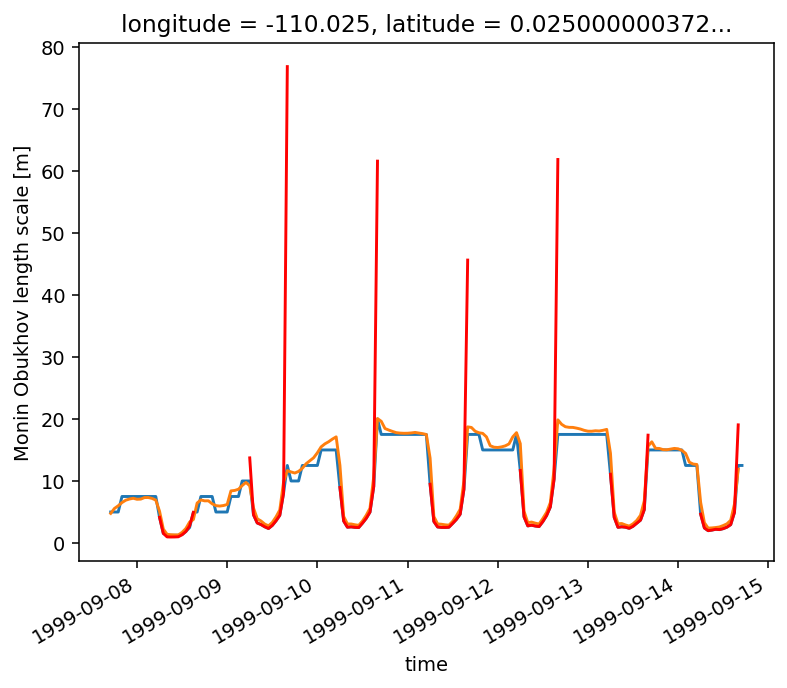

In [ ]:
h = pump.calc.calc_kpp_hbl(subset)
h.hbl.plot()
kpp.KPPhbl.plot()
h.hmonob.plot(color="r")

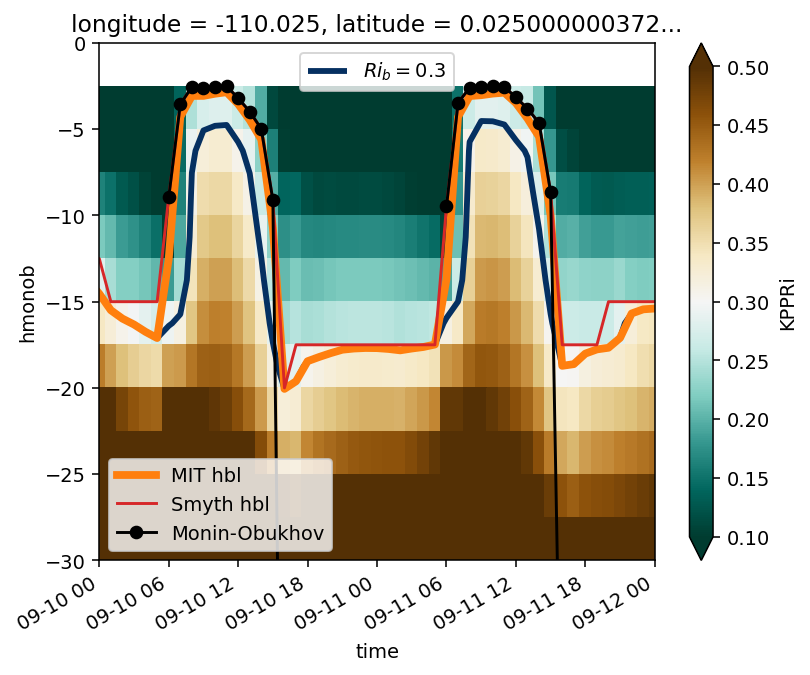

In [ ]:
kpp.KPPRi.plot(ylim=(-30, 0), x="time", center=0.3, vmin=0.1, cmap=mpl.cm.BrBG_r)
c = kpp.KPPRi.plot.contour(ylim=(-50, 0), linewidths=3, x="time", levels=[0.3])
(-kpp.KPPhbl).plot(color='C1', label="MIT hbl", lw=4)
(-h.hbl).plot(color="C3", label="Smyth hbl")
(-h.hmonob).plot(color="k", marker='o', label="Monin-Obukhov")
plt.ylim((-30, 0))
plt.xlim(("1999-09-10", "1999-09-12"))

leg = plt.legend(*c.legend_elements("Ri_b"))
plt.gca().add_artist(leg)

plt.legend()

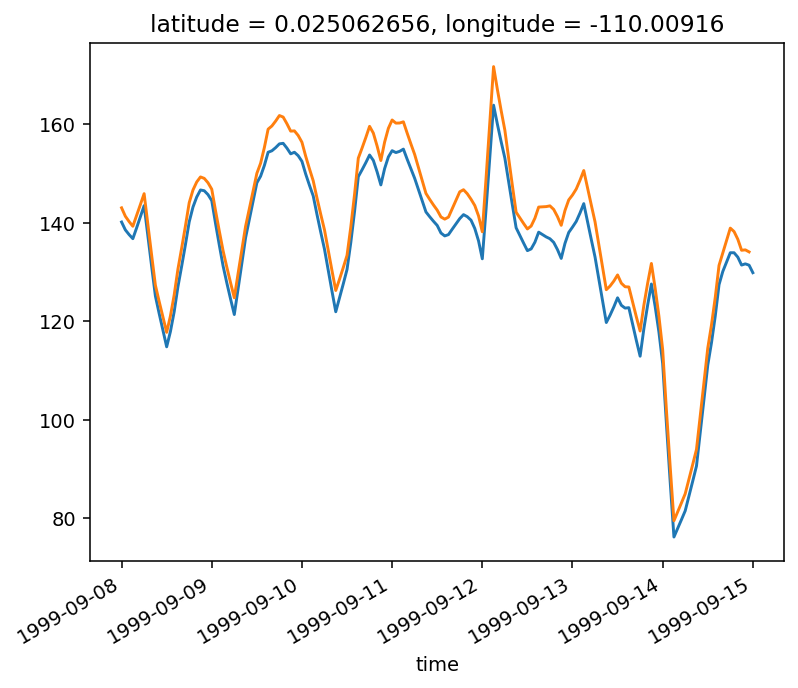

In [ ]:
(-(sub.netflux - sub.short)).plot()
(exf.EXFqnet - exf.EXFswnet.fillna(0)).plot()

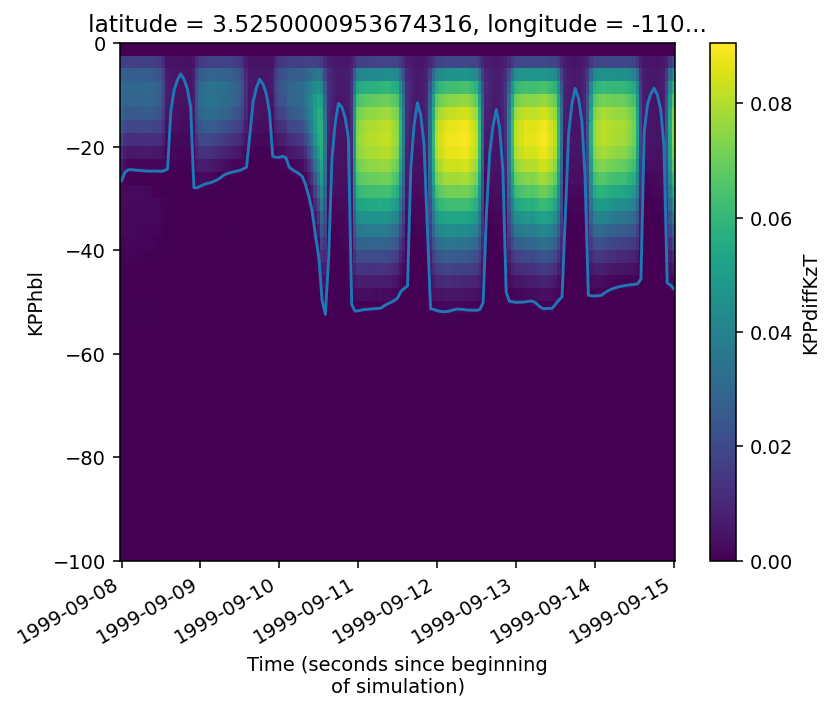

In [ ]:
station.KPPdiffKzT.sel(latitude=3.5, method="nearest").sel(depth=slice(-100)).plot()
(-1 * station.KPPhbl).sel(latitude=3.5, method="nearest").plot()

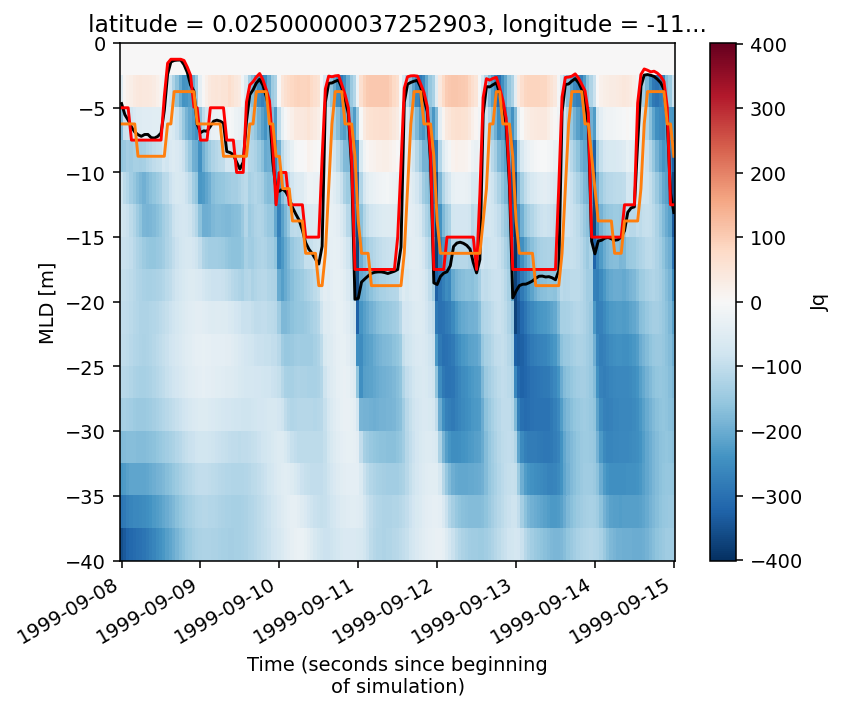

In [ ]:
subset.sel(depth=slice(-40)).Jq.plot()
(-1 * sub.KPPhbl).plot(color="k")
(-1 * h).plot(color="r")
(pump.calc.get_mld(sub.dens)).plot(color="C1")